# Kaggle - Titanic - Machine Learning from Disaster

A task as part of my data science class:

Requirements:

1. Add at least 2 new features to the dataset (explain your reasoning below)
2. Use KNN (and only KNN) to predict survival
3. Explain your process below and choice of K
4. Make a submission to the competition and provide a link to your submission below.
5. Show your code below

Lets start by reading in our data

In [103]:
import pandas as pd

train_Data_DF = pd.read_csv("./Data/train.csv")
test_Data_DF = pd.read_csv("./Data/test.csv")

Lets feature engineer to add to new columns:

- Title from Name: 

    Lets Extract titles (Mr, Mrs, Miss, Master, etc.) from the passenger names. The title can indicate social status, gender, and marital status, which might correlate with survival chances. For example, women (Mrs, Miss) and nobility (titles indicating a higher social rank) might have had higher priority for lifeboats.

- Family Size: 

    Lets Combine SibSp (number of siblings/spouses aboard) and Parch (number of parents/children aboard) to create a new feature that represents the total number of family members on board. This could affect survival as those with families might have prioritized keeping their family together or ensuring their family's safety over their own.

- IsAlone: 

    The intuition behind creating an IsAlone feature is that the survival chances might differ between passengers who were traveling alone and those who were with family. Being alone or with family could impact a passenger's mobility, decision-making, and access to resources during the evacuation.



In [104]:
# Extract titles from the Name column
train_Data_DF['Title'] = train_Data_DF['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_Data_DF['Title'] = test_Data_DF['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


- train_Data_DF['Name'] accesses the Name column in the training DataFrame.

- .str.extract(' ([A-Za-z]+)\.', expand=False) applies the regular expression to each name, extracting the title.
    - (space): The search starts after a space, ensuring we don't start extracting from the beginning of the Lastname.

    - ([A-Za-z]+): This part captures one or more (+) alphabetical characters (A-Za-z). This is where the title will be matched, as titles are made up of letters only.
    
    - \.: This looks for a literal period (.). Titles in the dataset are followed by a period (e.g., "Mr."), making this a reliable way to end the capture.

- The extracted title is then assigned to a new column in the DataFrame called 'Title'.

In [105]:
for df in [train_Data_DF, test_Data_DF]:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')


The code provided does a few things:

- It first replaces rare titles (like 'Lady', 'Countess', 'Capt', 'Col', etc.) with 'Rare'. This groups various titles of nobility or uncommon professional titles into a single 'Rare' category, acknowledging their unique status without overcomplicating the model.

- It replaces titles with their common equivalents, such as converting 'Mlle' and 'Ms' to 'Miss', and 'Mme' (Madame) to 'Mrs', to ensure consistency in the dataset.

In [106]:
for df in [train_Data_DF, test_Data_DF]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

FamilySize is a combination of SibSp and Parch plus 1 (for the passenger themselves). This feature can be useful to understand if having family members on board affects a passenger's survival rate.

In [107]:
for df in [train_Data_DF, test_Data_DF]:
    df['IsAlone'] = 0 # Initially, assume no passengers are alone
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1 # If FamilySize is 1, the passenger is alone


- df['IsAlone'] = 0 initializes a new column IsAlone for every passenger in the DataFrame, setting it to 0 by default, indicating that passengers are not alone.

- df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1 this line looks for passengers whose FamilySize equals 1—meaning they have no family members aboard—and sets their IsAlone status to 1, indicating they are traveling alone.


### Applying One-Hot Encoding to the Titanic Dataset

One-hot encoding is a common method to convert categorical data into a numerical format. It creates new columns for each category of the variable, with a 1 indicating the presence of the category and 0 indicating its absence for each row. This is particularly useful for non-ordinal categorical variables where no inherent order exists between the categories (e.g., Embarked).

The Sex column can be easily converted into numeric format because it typically has two categories (male and female).

In [108]:
train_Data_DF = pd.get_dummies(train_Data_DF, columns=['Sex'], drop_first=True)
test_Data_DF = pd.get_dummies(test_Data_DF, columns=['Sex'], drop_first=True)

drop_first=True is used to avoid redundancy. For binary categories like Sex, you only need one column where, for example, 1 could represent male and 0 could represent female.

In [109]:
train_Data_DF = pd.concat([train_Data_DF, pd.get_dummies(train_Data_DF['Title'], prefix='Title')], axis=1)
test_Data_DF = pd.concat([test_Data_DF, pd.get_dummies(test_Data_DF['Title'], prefix='Title')], axis=1)

- pd.concat([...], axis=1): The pd.concat() function is used to concatenate pandas objects along a particular axis. Here's what the parameters mean:

    - The first parameter is a list of DataFrames to concatenate. In this case, we concatenate the original DataFrame (train_Data_DF or test_Data_DF) with the new DataFrame of dummy variables created from the Title column.

    - axis=1 tells pandas to concatenate columns, not rows. When concatenating DataFrames, axis=0 would stack the DataFrames on top of each other, increasing the number of rows. axis=1 places the new columns from the second DataFrame (the one-hot encoded titles) alongside the existing columns of the first DataFrame.


In [110]:
train_Data_DF = pd.get_dummies(train_Data_DF, columns=['Embarked'], prefix='Embarked')
test_Data_DF = pd.get_dummies(test_Data_DF, columns=['Embarked'], prefix='Embarked')


In [111]:
print(train_Data_DF.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   
5                                   Moran, Mr. James   NaN      0      0   
6                            McCarthy, Mr. Timothy J  54.0      0      

In [112]:
train_Data_DF = train_Data_DF.drop('Cabin', axis=1)
test_Data_DF = test_Data_DF.drop('Cabin', axis=1)

Dropping the cabin column for now as its very nuanced.

### Applying KNN - K Nearest Neighbors

In [113]:
# Step 1: Preparing the data
# Dropping non-numeric and target columns
X = train_Data_DF.drop(['PassengerId', 'Name', 'Ticket', 'Survived','Title'], axis=1)
y = train_Data_DF['Survived']

Imputation involves filling in missing values with substitute values, such as the mean, median, or mode of the column. This allows you to retain all your data points, which is often preferable for maintaining dataset integrity and size.

For numerical columns like Age and Fare, we can use the median or mean.

In [114]:
from sklearn.impute import SimpleImputer

# Initialize the imputer for numeric data
num_imputer = SimpleImputer(strategy='median')

# Assuming 'Age' and 'Fare' are the only numeric columns with missing values
X[['Age', 'Fare']] = num_imputer.fit_transform(X[['Age', 'Fare']])

# Now, there shouldn't be any NaN values in the dataset, but let's verify:
null_counts = X.isnull().sum()
print("\nNumber of null values in each column after imputation:\n", null_counts)


Number of null values in each column after imputation:
 Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
FamilySize      0
IsAlone         0
Sex_male        0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64


In [115]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Splitting the training dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Initializing lists to store accuracies
train_accuracies = []
test_accuracies = []

# Step 3: Iterating over different values of K
for K in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train_scaled, y_train)
    
    # Recording accuracies
    train_accuracy = knn.score(X_train_scaled, y_train)
    test_accuracy = knn.score(X_test_scaled, y_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


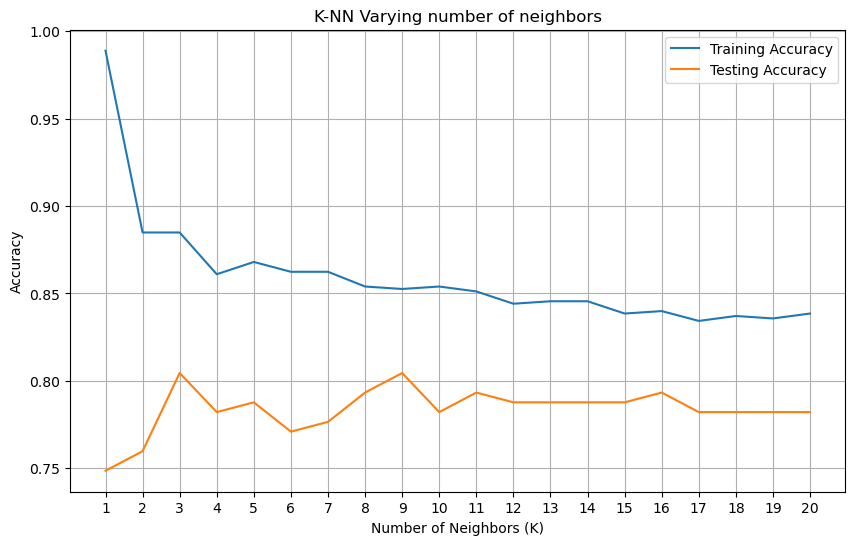

In [116]:
# Step 4: Plotting accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 21), test_accuracies, label='Testing Accuracy')
plt.title('K-NN Varying number of neighbors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.grid(True)
plt.show()

the peaks are around 3 or 9. Since both give similar testing accuracy, we prefer the higher K (9) as it may help the model generalize better by considering more neighbors.

### Applying Model to Testing Data

Lets pre-process the testing data to match the training data to start.

In [117]:
X_test_real = test_Data_DF.drop(['PassengerId', 'Name', 'Ticket', 'Title'], axis=1)

In [118]:
print(X_test_real.head(10))

   Pclass   Age  SibSp  Parch     Fare  FamilySize  IsAlone  Sex_male  \
0       3  34.5      0      0   7.8292           1        1         1   
1       3  47.0      1      0   7.0000           2        0         0   
2       2  62.0      0      0   9.6875           1        1         1   
3       3  27.0      0      0   8.6625           1        1         1   
4       3  22.0      1      1  12.2875           3        0         0   
5       3  14.0      0      0   9.2250           1        1         1   
6       3  30.0      0      0   7.6292           1        1         0   
7       2  26.0      1      1  29.0000           3        0         1   
8       3  18.0      0      0   7.2292           1        1         0   
9       3  21.0      2      0  24.1500           3        0         1   

   Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Rare  Embarked_C  \
0             0           0         1          0           0           0   
1             0           0         0       

In [119]:
# Use the imputer that was already fit to the training data
# Don't call fit again, just transform
X_test_real[['Age', 'Fare']] = num_imputer.transform(X_test_real[['Age', 'Fare']])

# Only call transform on the test data, do not re-fit
# It's crucial that the transform method (and not fit_transform) 
# is used on the actual test dataset because you want to apply the 
# exact same scaling that you applied to your training data.
X_test_real_scaled = scaler.transform(X_test_real)

# Now, there shouldn't be any NaN values in the dataset, but let's verify:
null_counts = X_test_real.isnull().sum()
print("\nNumber of null values in each column after imputation:\n", null_counts)


Number of null values in each column after imputation:
 Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
FamilySize      0
IsAlone         0
Sex_male        0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64


In [120]:
# Train the model on the full training dataset
knn_final = KNeighborsClassifier(n_neighbors=9)
knn_final.fit(X, y)  # X and y are the full preprocessed training data

KNeighborsClassifier(n_neighbors=9)

In [121]:
# Predict survival on the test dataset
predictions = knn_final.predict(X_test_real_scaled)
submission_df = pd.DataFrame({'PassengerId': test_Data_DF['PassengerId'], 'Survived': predictions})
submission_df.to_csv('submission.csv', index=False)

/Users/rsudhir/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
